In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils.merge_tools import merge_n_case_ids

In [2]:
data_dir = '../data/processed/grouped/new_aggs/'
base_file = '../data/raw/csv_files/train/train_base.csv'

## First SVM Pass

Using all case_ids.

In [3]:
df = merge_n_case_ids(
    n_ids=50000,
    data_dir=data_dir,
    path_to_base=base_file,
    use_0=True,
    as_pandas=True,
    random_state=28
)
case_ids_list = list(df['case_id'])

df_rest = merge_n_case_ids(
    n_ids=50000,
    data_dir=data_dir,
    path_to_base=base_file,
    use_0=False,
    as_pandas=True,
    case_id_list=case_ids_list,
    random_state=28
)

In [4]:
df = pd.merge(df, df_rest, how='left', on='case_id', suffixes=("", "_r"))

In [5]:
df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,empls_employedfrom_796D_min_year,empls_employedfrom_796D_min_month,empls_employedfrom_796D_min_day,empls_employedfrom_796D_max_year,...,pmts_pmtsoverdue_635A_median_r,pmts_dpdvalue_108P_sum_r,pmts_pmtsoverdue_635A_sum_r,pmts_date_1107D_distinct_r,pmts_date_1107D_min_year_r,pmts_date_1107D_min_month_r,pmts_date_1107D_min_day_r,pmts_date_1107D_max_year_r,pmts_date_1107D_max_month_r,pmts_date_1107D_max_day_r
0,1273180,2019-02-04,201902,4,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1022832,2020-09-23,202009,90,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1304266,2019-03-09,201903,9,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2583335,2019-06-12,201906,23,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,823208,2019-10-06,201910,39,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.dtypes.value_counts()

float64    2495
int8         99
object       28
uint32        8
int64         7
bool          2
int32         2
Name: count, dtype: int64

In [7]:
df.shape

(50000, 2641)

### Clean Data

In [8]:
# Drop empty columns
df = df.dropna(how='all', axis=1)

In [9]:
del df_rest

In [10]:
# Extract date info from base
df['date_decision'] = pd.to_datetime(df['date_decision'])
df['dec_day'] = df['date_decision'].dt.day
df['dec_month'] = df['date_decision'].dt.month
df['dec_year'] = df['date_decision'].dt.year

# Drop redundant information
df = df.drop(columns=[
    'MONTH', 'MONTH_r', 'WEEK_NUM', 'WEEK_NUM_r', 
    'date_decision', 'date_decision_r','case_id',
    'target_r'
])

In [11]:
# Get bool cols with na
na_bool_cols = df.select_dtypes(include=['O']).columns

# Remove redundant
na_bool_cols = [ col for col in na_bool_cols if col.__contains__('min') ]
df = df.drop(columns=na_bool_cols)

In [12]:
# Create null flags
na_cols = df.columns[df.isna().any()].to_list()
isna_cols = [ col + '_isna' for col in na_cols ]
na_df = df[na_cols].isna()
na_df.columns = isna_cols

df = pd.concat([df, na_df], axis=1)

# Free memory
del na_df

In [13]:
# Drop columns below treshold
df = df.dropna(thresh=len(df)//10, axis=1)

In [14]:
X = df.drop(columns='target')
y = df[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=28)

# Free memory
del df, X, y

In [15]:
X_train.dtypes.value_counts()

bool       2385
float64    1595
int8         99
uint32        8
object        7
int32         5
Name: count, dtype: int64

In [16]:
# Fill na from X_train median and mode
X_train[X_train.select_dtypes(exclude=['O', 'bool']).columns] = X_train.select_dtypes(exclude=['O', 'bool']).fillna(X_train.median())
X_test[X_test.select_dtypes(exclude=['O', 'bool']).columns] = X_test.select_dtypes(exclude=['O', 'bool']).fillna(X_train.median())
X_train[X_train.select_dtypes(include=['O', 'bool']).columns] = X_train.select_dtypes(include=['O', 'bool']).fillna(X_train.mode())
X_test[X_test.select_dtypes(include=['O', 'bool']).columns] = X_test.select_dtypes(include=['O', 'bool']).fillna(X_train.mode())

In [17]:
remain_na_cols = X_train.columns[X_train.isna().any()].to_list()
for col in remain_na_cols:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_train[col].mode()[0])

/var/folders/sp/dv4f3qgx20vb8f6ghm2mh5880000gn/T/ipykernel_60680/3771812320.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
/var/folders/sp/dv4f3qgx20vb8f6ghm2mh5880000gn/T/ipykernel_60680/3771812320.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test[col] = X_test[col].fillna(X_train[col].mode()[0])


### Reduce Dimensions

In [18]:
# First scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Get components and explained variance
pca = PCA(n_components=1000)
pca.fit(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

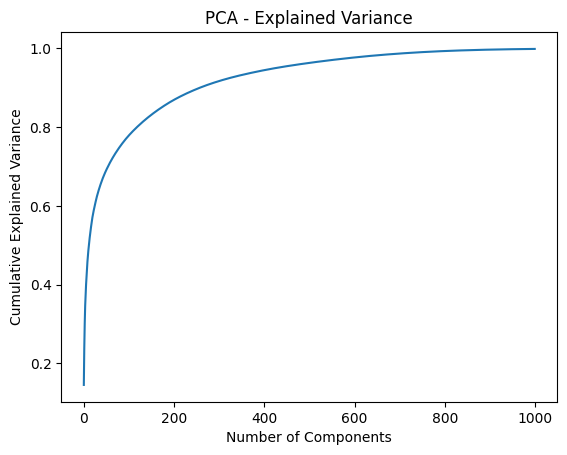

In [20]:
plt.plot(cumsum)
plt.title('PCA - Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

In [21]:
# Get number of components
d_99 = np.argmax(cumsum >= 0.99) + 1
d_95 = np.argmax(cumsum >= 0.95) + 1

print(f'99% Explained Variance: {d_99} components')
print(f'95% Explained Variance: {d_95} components')

99% Explained Variance: 740 components
95% Explained Variance: 425 components


In [22]:
# Fit
pca_95 = PCA(n_components=d_95)
pca_95.fit(X_train_scaled)

# Transform
X_train_pca_95 = pca_95.transform(X_train_scaled)
X_test_pca_95 = pca_95.transform(X_test_scaled)

In [23]:
pca_df = pd.DataFrame({
    'pc_1': list(X_train_pca_95[:, 0]), 
    'pc_2': list(X_train_pca_95[:, 1]), 
    'target': list(y_train['target'])
})

We can see in the first 2 components there are no easy decision boundaries to construct.

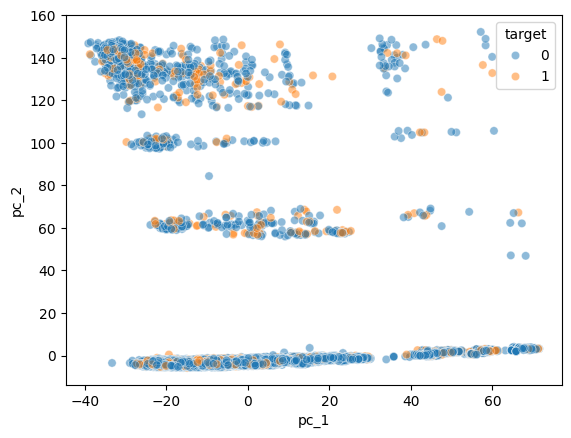

In [24]:
sns.scatterplot(
    data=pca_df,
    x='pc_1', 
    y='pc_2', 
    hue='target',
    alpha=0.5
)
plt.show()

In [25]:
# Start with defaults
clf = LinearSVC()
clf.fit(X_train_pca_95, y_train)

y_train_pred_95 = clf.predict(X_train_pca_95)
y_test_pred_95 = clf.predict(X_test_pca_95)

/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
print('Train Report')
print(classification_report(y_train, y_train_pred_95))
print('Test Report')
print(classification_report(y_test, y_test_pred_95))

Train Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     34658
           1       0.27      0.28      0.28      5342

    accuracy                           0.80     40000
   macro avg       0.58      0.58      0.58     40000
weighted avg       0.81      0.80      0.81     40000

Test Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      8664
           1       0.27      0.29      0.28      1336

    accuracy                           0.80     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.81      0.80      0.80     10000



In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_95, pos_label=1)
print(f'AUC: {auc(fpr, tpr)}')

AUC: 0.5849637290515921


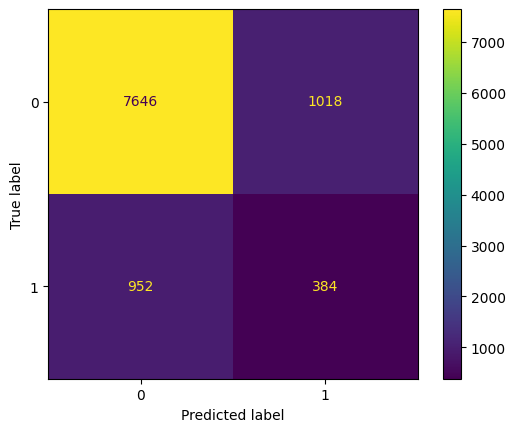

In [28]:
cm = confusion_matrix(y_test, y_test_pred_95)
cm_display = ConfusionMatrixDisplay(cm).plot()